In [20]:
import matplotlib.pyplot as plt

from BilinearModel_CSVGenerator import write_to_csv
from Examples.Parameters import Parameters
from BilinearModel_Hemodynamics import *
from BilinearModel_Neurodynamics import *
from BilinearModel_Optics import *
from BilinearModel_SemisyntheticNoise import *
from BilinearModel_StimulusGenerator import *
from BilinearModel_SyntheticNoise import *
from BilinearModel_Plots import *

In [21]:
def fNIRS_Process(Parameters, NoiseSelection, percentNoise=0):
    """
    Process the fNIRS data.

    Returns:
        U_stimulus: Stimulus signal
        timestamps: Array of timestamps
        Z: Neurodynamics
        dq, dh: Derivatives of blood volume and deoxyhemoglobin concentration
        Y: Optics output
        qj, pj: Hemodynamics data
    """
    U_stimulus, timestamps = bilinear_model_stimulus_train_generator(
        Parameters["freq"],
        Parameters["actionTime"],
        Parameters["restTime"],
        Parameters["cycles"],
        Parameters["A"].shape[0],
    )
    # Initialize the state of the neurodynamics
    Z0 = np.zeros([Parameters["A"].shape[0]])
    # Compute the neurodynamics of the system
    Z = Neurodynamics(
        Z0, timestamps, Parameters["A"], Parameters["B"], Parameters["C"], U_stimulus
    )

    # Process hemodynamics
    qj, pj = Hemodynamics(Z.T, Parameters["P_SD"], Parameters["step"])

    pj_noise = pj.copy()
    qj_noise = qj.copy()
    dq, dh = calculate_hemoglobin_changes(pj, qj)
    if percentNoise > 0:
        # PhysiologicalNoise Inclusion
        if NoiseSelection == "Synthetic":
            noise_types = [
                "heart",
                "breathing",
                "vasomotion",
                "white",
            ]  # Types of noise to generate
            # Example percent error
            noises_with_gains = synthetic_physiological_noise_model(
                timestamps, noise_types, pj_noise, percentNoise
            )
            # Labels corresponding to the noise types
            labels = ["Heart Rate", "Vasomotion", "Breathing Rate", "White"]

            # Combine the noises into hemodyanmics
            combined_noises = combine_noises(noises_with_gains, pj_noise.shape[0])

            # Add the combined noise to qj and pj
            qj_noise = qj_noise + combined_noises
            pj_noise = pj_noise + combined_noises

        elif NoiseSelection == "Semisynthetic":
            semisynthetic_noises = semisynthecticDataExtraction(
                Parameters["A"].shape[0], Parameters["freq"], len(timestamps)
            )

            qj_noise, pj_noise = add_noise_to_hemodynamics(
                qj_noise, pj_noise, semisynthetic_noises, percentNoise, timestamps
            )

    # Process optics
    Y, dq, dh = BilinearModel_Optics(pj_noise, qj_noise, U_stimulus, Parameters["A"])

    return U_stimulus, timestamps, Z, dq, dh, Y


In [22]:
def generateSignals_full(params, noise_type="Synthetic", percentNoise=1):
    parameters_dict = params
    parameters_dict["A"] = np.array(params["A"])
    parameters_dict["B"] = np.array(params["B"])
    parameters_dict["C"] = np.array(params["C"])

    U_stimulus, timestamps, Z, dq, dh, Y = fNIRS_Process(
        parameters_dict, noise_type, percentNoise
    )

    response = {
        "U_stimulus": U_stimulus.tolist(),
        "timestamps": timestamps.tolist(),
        "Z": Z.T.tolist(),
        "dq": dq.tolist(),
        "dh": dh.tolist(),
        "Y": Y.tolist(),
    }
    return timestamps, U_stimulus, Z, dq, dh, Y, response


In [23]:
#Generate signals for the second set of parameters (original)
timestamps, U_stimulus, Z, dq, dh, Y, _ = generateSignals_full(Parameters, "Synthetic",10)

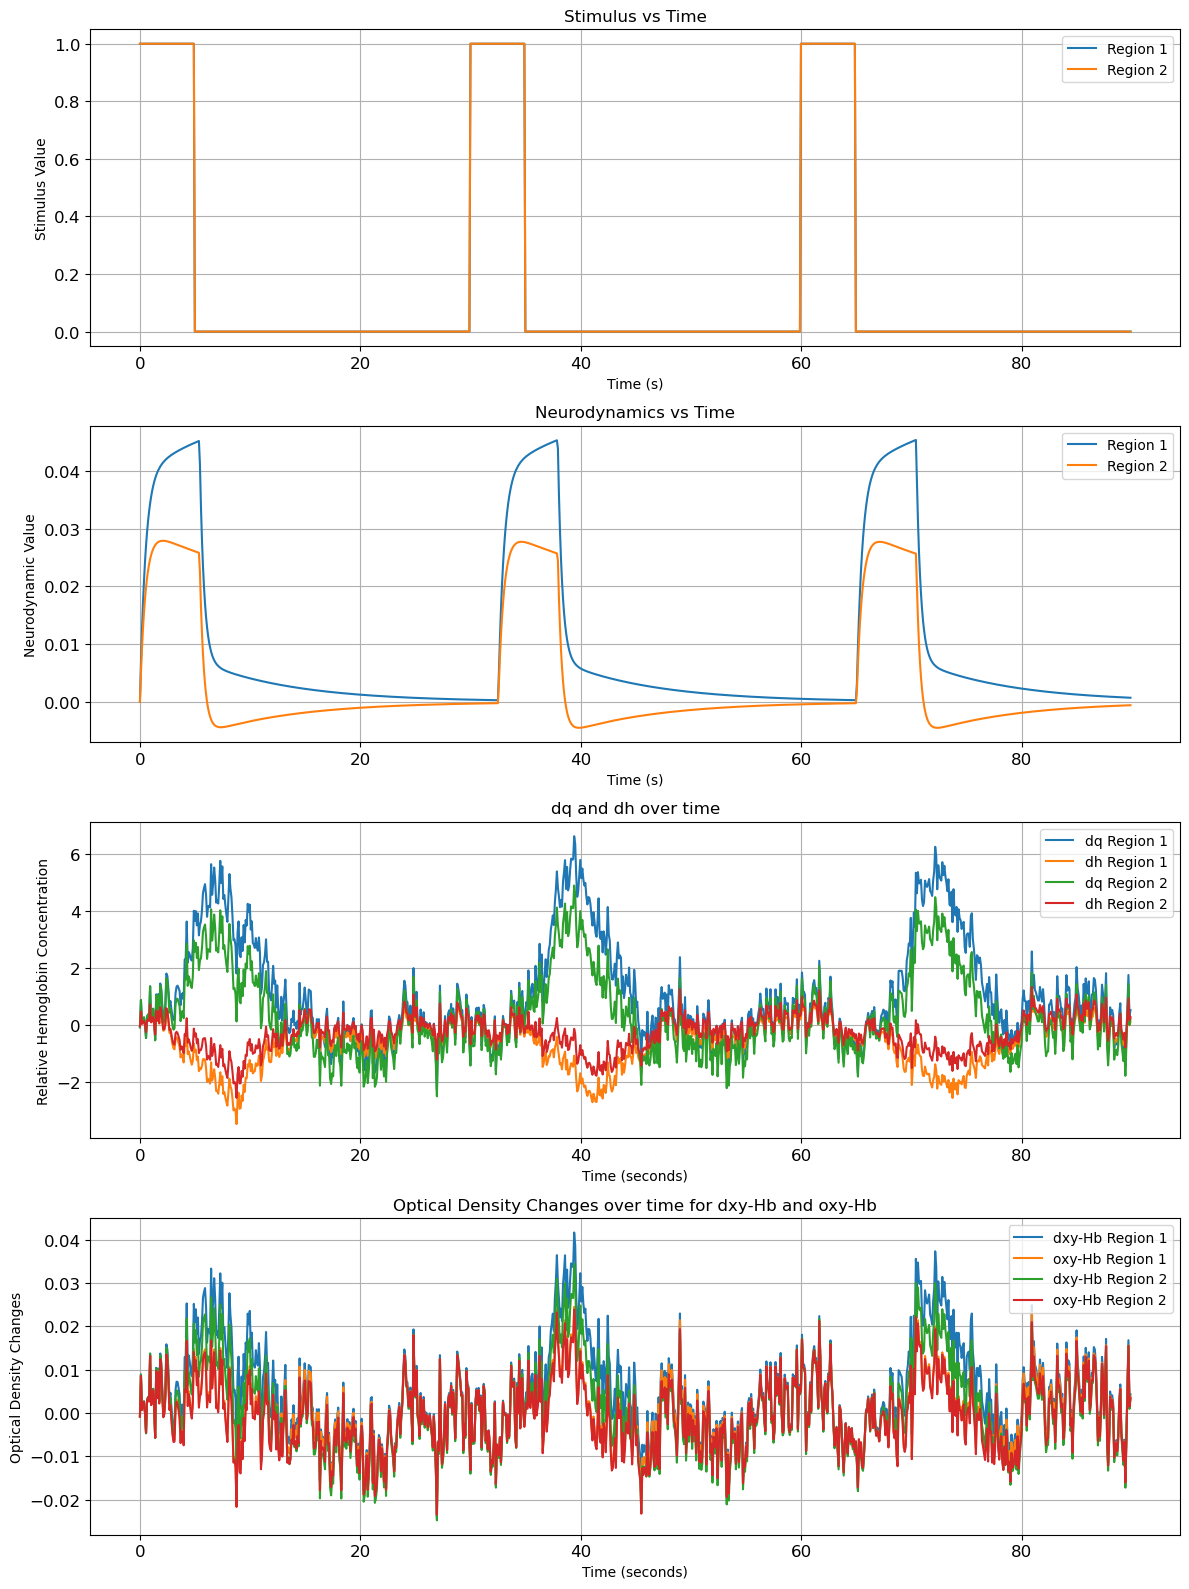

In [24]:
fig, axs = plt.subplots(4, 1, figsize=(12, 16))
plot_Stimulus(U_stimulus, timestamps,fig,axs[0],[],[])
plot_neurodynamics(Z,timestamps, fig,axs[1],[],[])
plot_DHDQ(dq,dh, timestamps, fig,axs[2],[],[])
plot_Y(Y,timestamps,fig,axs[3],[],[],)

plt.tight_layout()
plt.show()

In [28]:
#CSV Import
write_to_csv(Y, timestamps, "../data/DataExport-Example.csv")

Data written to ../data/DataExport-Example.csv
